# Bats data selection randomization 

Import libraries

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import random
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress the specific warning
warnings.filterwarnings("ignore", category=Warning)

Read data

In [2]:
df1 = pd.read_csv('ubna_data_01_collected_audio_records.csv', index_col=0)
df2 = pd.read_csv('ubna_data_02_collected_audio_records.csv', index_col=0)
df3 = pd.read_csv('ubna_data_03_collected_audio_records.csv', index_col=0)

df = pd.concat([df1, df2, df3], ignore_index=True)

# print(df['Datetime UTC'].dtype)
df['Datetime UTC'] = pd.to_datetime(df['Datetime UTC'])
# print(df['Datetime UTC'].dtype)

df2022 = df.loc[df['Datetime UTC'].dt.year == 2022]
#print(df2022['Datetime UTC'].dt.month.unique())
#print(df2022['Site name'].unique())
df2022 = df2022[df2022['Site name'] != '(Site not found in Field Records)']
df2022 = df2022[df2022['File metadata'] != 'Is empty!']
df2022 = df2022[~df2022['File status'].str.startswith('Not usable')]
# print(df2022['File status'].unique())

df2022 = df2022.reset_index(drop=True)
#display(df2022)


In [3]:
dfw = pd.read_csv('2022-2023-uwa.csv', header=[1])

# Convert 'Date' column to datetime format
dfw['Datetime UTC'] = pd.to_datetime(dfw['Date'] + ' ' + dfw['Time'])

# rename the column "Speed" to "Wind Speed"
dfw = dfw.rename(columns={'Speed': 'Wind Speed'})

dfw2022 = dfw.loc[dfw['Datetime UTC'].dt.year == 2022]
#display(dfw2022)


For the code in the codechunck below: 

It looks like the original weather dataset had a few strings in the wind speed column (I assume these are the typos). Thus, here I change the data in all the columns that I will use in numeric data type just to in case.

In [4]:
dfw2022['Rain'] = pd.to_numeric(dfw2022['Rain'], errors='coerce')
dfw2022['Wind Speed'] = pd.to_numeric(dfw2022['Wind Speed'], errors='coerce')

Since the length of each measurement in the two databases is not the same, here, I take the time interval of the recorder as the basis, and take the weather data in the recorder time interval to take the mean (for the wind speed) and sum (for the precipitation) and merge them into the recorder database.

Therefore, the database generated is the average wind speed and total rainfall from the last record time to this record time.

In [5]:
unique_recording_date = df2022['Datetime UTC'].unique()

save_mean = pd.DataFrame()

for i in range(len(unique_recording_date) - 1):
    start_date = unique_recording_date[i]
    end_date = unique_recording_date[i+1]
    sum_rain = dfw2022.loc[(dfw2022['Datetime UTC'] >= start_date) & (dfw2022['Datetime UTC'] <= end_date), 'Rain'].sum()
    mean_speed = dfw2022.loc[(dfw2022['Datetime UTC'] >= start_date) & (dfw2022['Datetime UTC'] <= end_date), 'Wind Speed'].mean()
    result = {'Datetime UTC': end_date, 'Sum Rain': sum_rain, 'Mean Wind Speed': mean_speed}
    save_mean = save_mean.append(result, ignore_index=True)

display(save_mean)

,Datetime UTC,Sum Rain,Mean Wind Speed
0,2022-06-14 23:00:00,0.0,9.720833
1,2022-06-14 23:30:00,0.0,10.070968
2,2022-06-15 00:00:00,0.0,9.512903
3,2022-06-15 00:30:00,0.0,9.032258
4,2022-06-15 01:00:00,0.0,9.287097
...,...,...,...
9495,2022-12-22 21:32:12,0.0,5.622581
9496,2022-12-22 22:01:38,0.0,9.865517
9497,2022-12-22 22:31:30,0.0,10.376667
9498,2022-12-22 23:32:04,0.0,9.600000


Check the max / min in the dataset to set the bar for "heavy wind" and "heavy rain"

In [6]:
print(save_mean['Sum Rain'].min())
print(save_mean['Sum Rain'].max())
print(save_mean['Mean Wind Speed'].min())
print(save_mean['Mean Wind Speed'].max())
#display(save_mean[save_mean['Sum Rain']> 0.02])
#display(save_mean[save_mean['Mean Wind Speed']>15])

0.0
4.09
3.3125
25.19677419354839


Merge the generate dataset and the recorder dataset together.

In [7]:
combined_df = pd.merge(df2022, save_mean, on='Datetime UTC')
#display(combined_df)

**Define the extreme weather**

Plot the distribution for the rainfall and the wind speed for the auidomoth recording period.

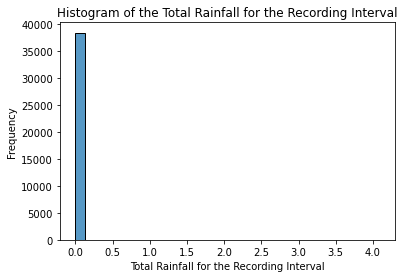

In [8]:
sns.histplot(combined_df, x= 'Sum Rain', bins = 30)
plt.title('Histogram of the Total Rainfall for the Recording Interval')
plt.xlabel('Total Rainfall for the Recording Interval')
plt.ylabel('Frequency')
plt.show()

In [9]:
upper_quantile_sum_rain = pd.Series(combined_df['Sum Rain']).quantile(0.95)
print(upper_quantile_sum_rain)

0.01


The Total rainfall in this dataset is highly right-skewed with some large outliers. The 0.95 quantile of the dataset is 0.01. Therefore, for a Audiomoth recording interval, if the total rainfall surpass 0.01, it's considered under the extreme weather condition.

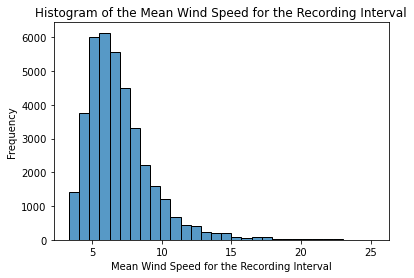

In [10]:
sns.histplot(combined_df, x= 'Mean Wind Speed', bins = 30)
plt.title('Histogram of the Mean Wind Speed for the Recording Interval')
plt.xlabel('Mean Wind Speed for the Recording Interval')
plt.ylabel('Frequency')
plt.show()

In [11]:
upper_quantile_mean_wind_speed = pd.Series(combined_df['Mean Wind Speed']).quantile(0.95)
print(upper_quantile_mean_wind_speed)

11.293548387096774


The Mean Wind Speed in this dataset is right-skewed. The 0.95 quantile of the dataset is around 11.29. Therefore, for a Audiomoth recording interval, if the average wind speed surpass 11.29, it's considered under the extreme weather condition.

 **Select 2 rows for different location each month:**
 
 Extreme weather conditions are defined as 'Mean Wind Speed' exceeding 11.29 or 'Sum Rain' surpassing 0.01. If these conditions are met, the selection process will ensure that at least one row represents extreme weather conditions, while the other row represents normal weather conditions. Otherwise, the program will select 2 row from the normal weather condition. The selected rows will be meticulously and randomly chosen from the dataset. But here, to be able to reproduce my code, I set up random state = 1.

In [12]:
combined_df['Month'] = combined_df['Datetime UTC'].dt.month

def check_extreme_conditions(combined_df):
    return combined_df['Mean Wind Speed'] >= 11.29 or combined_df['Sum Rain'] >= 0.01

# Initialize an empty DataFrame to store the selected rows
selected_rows = pd.DataFrame()
# Initialize an empty list to store the site name, month, whether this combination is selected,
# and whether the selected files contain one file under the extreme weather condition
record = []

grouped_data = combined_df.groupby(['Site name', 'Month'])

# Iterate through each group to select rows
for site_month, group_data in grouped_data:
    extreme_weather_data = group_data[group_data.apply(check_extreme_conditions, axis=1)]
    normal_weather_data = group_data[~group_data.apply(check_extreme_conditions, axis=1)]

    # check to make sure there are enough files from a particular site and month under normal condition
    if len(normal_weather_data) >=2:
        # check whether there is at least 1 file from a particular site and month under the extreme weather condition
        if len(extreme_weather_data) >=1:
            selected_extreme_row = extreme_weather_data.sample(n=1, random_state=1)
            selected_normal_row = normal_weather_data.sample(n=1, random_state=1)
            # add a column "Condition" to mark the condition of the selected file
            if selected_extreme_row['Mean Wind Speed'].values[0] >= 11.29:
                selected_rows = selected_rows.append(selected_extreme_row.assign(Condition='Extreme Wind'))
            else:
                selected_rows = selected_rows.append(selected_extreme_row.assign(Condition='Extreme Rain'))
            selected_rows = selected_rows.append(selected_normal_row.assign(Condition='Normal'))
            # add the site month information to the record
            record.append([site_month[0], site_month[1], True, True])
    
        else:
            selected_normal_row = normal_weather_data.sample(n=2, random_state=1)
            selected_rows = selected_rows.append(selected_normal_row.assign(Condition='Normal'))
            record.append((site_month[0], site_month[1], True, False))
    else:
        record.append((site_month[0], site_month[1], False, False))


Display the selected rows

In [13]:
display(selected_rows)

,Datetime UTC,Site name,Recover folder,AudioMoth #,SD card #,File path,File metadata,File status,Audiomoth temperature,Audiomoth battery,Sample rate,Audiomoth artist ID,File duration,Deployment notes,Sum Rain,Mean Wind Speed,Month,Condition
1648,2022-07-18 12:30:00,Carp Pond,recover-20220719,F,004,/mnt/ubna_data_01/recover-20220719/UBNA_004/20...,Recorded at 12:30:00 18/07/2022 (UTC) by Audio...,Usable for detection,19.6C,3.9V,250000,AudioMoth 249BC30461CBEB1A,1795,Case,0.01,7.464516,7,Extreme Rain
3263,2022-07-30 02:30:00,Carp Pond,recover-20220801,A,004,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Recorded at 02:30:00 30/07/2022 (UTC) by Audio...,Usable for detection,39.1C,4.0V,192000,AudioMoth 24F3190361CBE990,1795,Double Battery Pack; Ziploc Bag; Recording whe...,0.00,7.696774,7,Normal
5274,2022-08-12 23:30:00,Carp Pond,recover-20220815,A,005,/mnt/ubna_data_01/recover-20220815/UBNA_005/20...,Recorded at 23:30:00 12/08/2022 (UTC) by Audio...,Usable for detection,34.7C,4.0V,192000,AudioMoth 24F3190361CBE990,1795,Double Battery Pack; Ziploc Bag; Pond is receding,0.00,11.703226,8,Extreme Wind
5499,2022-08-14 13:00:00,Carp Pond,recover-20220815,A,005,/mnt/ubna_data_01/recover-20220815/UBNA_005/20...,Recorded at 13:00:00 14/08/2022 (UTC) by Audio...,Usable for detection,19.6C,3.9V,192000,AudioMoth 24F3190361CBE990,1795,Double Battery Pack; Ziploc Bag; Pond is receding,0.00,5.332258,8,Normal
14474,2022-09-22 17:00:00,Carp Pond,recover-20220922,D,4,/mnt/ubna_data_02/recover-20220922/UBNA_004/20...,Recorded at 17:00:00 22/09/2022 (UTC) by Audio...,Usable for detection,22.6C,3.8V,192000,AudioMoth 249BC30461CBE637,1795.00127083333,Panasonic; Temperatures have begun dropping as...,0.00,11.409677,9,Extreme Wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17848,2022-10-05 04:00:00,Telephone Field,recover-20221006,A,1,/mnt/ubna_data_02/recover-20221006/UBNA_001/20...,Recorded at 04:00:00 05/10/2022 (UTC) by Audio...,Usable for detection,20.2C,4.0V,192000,AudioMoth 24F3190361CBE990,1795.00127083333,IKEA,0.00,4.016129,10,Normal
26045,2022-11-04 17:00:00,Telephone Field,recover-20221110,A,7,/mnt/ubna_data_02/recover-20221110/UBNA_007/20...,Recorded at 17:00:00 04/11/2022 (UTC) by Audio...,Usable for detection,16.3C,4.0V,192000,AudioMoth 24F3190361CBE990,300.001270833333,Panasonic,0.00,18.980645,11,Extreme Wind
29248,2022-11-16 07:30:00,Telephone Field,recover-20221123,A,1,/mnt/ubna_data_02/recover-20221123/UBNA_001/20...,Recorded at 07:30:00 16/11/2022 (UTC) by Audio...,Usable for detection,4.4C,4.0V,192000,AudioMoth 24F3190361CBE990,300.001270833333,Panasonic,0.00,3.490323,11,Normal
37596,2022-12-27 05:00:00,Telephone Field,recover-20230110,A,11,/mnt/ubna_data_02/recover-20230110/UBNA_011/20...,Recorded at 05:00:00 27/12/2022 (UTC) by Audio...,Usable for detection,11.5C,3.9V,192000,AudioMoth 24F3190361CBE990,300.001270833333,Panasonic,0.07,7.900000,12,Extreme Rain


Display whether a site-month combination has 2 sampling files, and whether it has a file for the extreme weather.

In [14]:
record =  pd.DataFrame(record, columns=['Site Name', 'Month', 'Selected?', 'Has Extreme Weather?'])
display(record)

,Site Name,Month,Selected?,Has Extreme Weather?
0,Carp Pond,7,True,True
1,Carp Pond,8,True,True
2,Carp Pond,9,True,True
3,Carp Pond,10,True,True
4,Carp Pond,11,True,True
5,Carp Pond,12,True,True
6,Central Pond,7,True,True
7,Central Pond,8,True,True
8,Central Pond,9,True,True
9,Central Pond,10,True,True


Save the generated randomized dataset in the folder location.

In [17]:
selected_rows.to_csv('selection_under_randomization_file.csv', index=False)